In [1]:
import importlib
from libs import models, plots, trades, params
importlib.reload(models)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(trades)

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime

from tqdm import tqdm
import matplotlib.pyplot as plt   
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayDataset])


In [13]:
device               = params.device
ticker               = params.ticker
base_path            = params.save_path
look_back            = params.look_back
label_col            = params.label_col
feature_cols         = params.feature_cols
pred_threshold       = params.pred_threshold_man
regular_start        = params.regular_start
regular_start_shifted= params.regular_start_shifted
trailing_stop_thresh = params.trailing_stop_thresh_man

# month to inspect (YYYY-MM)
month_to_check = "2024-05"

# model path
val_rmse_str = "0.2619"   # same rmse in the filename

model_path = base_path / f"{ticker}_{val_rmse_str}.pth"
model_path

PosixPath('dfs training/GOOGL_0.2619.pth')

In [3]:
# Load the entire model object (architecture + weights)
model_best = torch.load(model_path, map_location=device, weights_only=False)
model_best.to(device).eval()
model_best

DualMemoryLSTM(
  (short_lstm): LSTM(5, 128, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (do_short): Dropout(p=0.3, inplace=False)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(128, 256, batch_first=True)
  (do_long): Dropout(p=0.4, inplace=False)
  (ln_long): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=256, out_features=1, bias=True)
)

In [4]:
dataset_test_path = base_path / f"{ticker}_test_ds.pt"
dataset_test = torch.load(dataset_test_path)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

dataset_val_path = base_path / f"{ticker}_val_ds.pt"
dataset_val = torch.load(dataset_val_path)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

dataloader_test, dataloader_val

(<torch.utils.data.dataloader.DataLoader at 0x773ccec13dd0>,
 <torch.utils.data.dataloader.DataLoader at 0x773ccecd2870>)

In [5]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(dataloader_val)
test_baseline = models.naive_rmse(dataloader_test)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.48778
Test zero‐forecast baseline RMSE = 0.37577


std val: 0.32359964
std test: 0.25987574


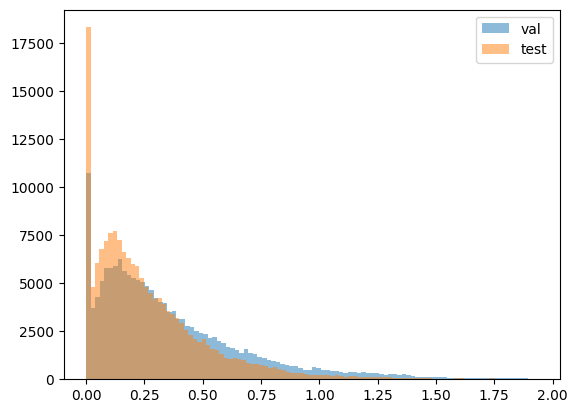

In [6]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in dataloader_val])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in dataloader_test])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [7]:

def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str = "Test",
    compute_rmse: bool = True,
    collect_preds: bool = False
):
    """
    Run your LSTM over every day in `loader`, with the same reset logic
    you use in rmse_over_windows and collect_predictions, but controlled by flags:
      - compute_rmse: if True, accumulates MSE and returns RMSE
      - collect_preds: if True, gathers every window's prediction into a flat array

    Returns:
      (rmse, preds) where:
        • rmse is a float if compute_rmse else None
        • preds is a 1D np.ndarray if collect_preds else None

    You can call:
      rmse, _     = evaluate_model(model, loader, device, split_name, True, False)
      _, preds    = evaluate_model(model, loader, device, split_name, False, True)
      rmse, preds = evaluate_model(model, loader, device, split_name, True, True)
    """
    # Move model & reset its internal state
    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_wd        = None
    total_sq_error = 0.0     # for RMSE
    total_windows  = 0       # counter for windows
    all_preds      = []      # list to store per-day preds

    # Iterate exactly as in two original functions
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", unit="day"):
            # Unpack: xb_day, yb_day, optional raw_*, wd
            xb_day, yb_day, *_, wd = batch
            wd_val = int(wd.item())

            # reset per-day LSTM
            model.reset_short()
            # reset per-week LSTM on weekday wrap
            if prev_wd is not None and wd_val < prev_wd:
                model.reset_long()
            prev_wd = wd_val

            # pull input windows and true targets
            x    = xb_day[0].to(device)        # shape: (W, look_back, F)
            y    = yb_day.view(-1).to(device)  # shape: (W,)

            # forward pass → get last-step prediction
            out  = model(x)                    # (W, look_back, 1)
            pred = out[:, -1, 0]               # (W,)

            # accumulate RMSE stats if requested
            if compute_rmse:
                total_sq_error += (pred - y).pow(2).sum().item()
                total_windows  += y.numel()

            # collect raw preds if requested
            if collect_preds:
                all_preds.append(pred.cpu().numpy())

    # compute final RMSE
    rmse = None
    if compute_rmse:
        rmse = math.sqrt(total_sq_error / total_windows)
        print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")

    # flatten collected predictions
    preds = None
    if collect_preds:
        preds = np.concatenate(all_preds, axis=0)

    return rmse, preds


In [8]:
val_rmse, _     = evaluate_model(model_best, dataloader_val, device, split_name="Validation")
test_rmse, _     = evaluate_model(model_best, dataloader_test, device, split_name="Test")

_, preds = evaluate_model(model_best, dataloader_test, device,
                          split_name="Test",
                          compute_rmse=False, collect_preds=True)

preds.shape

Validation: 100%|██████████| 410/410 [00:08<00:00, 48.07day/s]



Validation RMSE over 160310 windows = 0.26191


Test: 100%|██████████| 422/422 [00:08<00:00, 51.34day/s]



Test RMSE over 165002 windows = 0.23055


Test: 100%|██████████| 422/422 [00:11<00:00, 36.79day/s]


(165002,)

In [9]:

def add_pred_actions(
    preds: np.ndarray,
    csv_dir: str = "./dfs training"
) -> pd.DataFrame:
    path_csv = f"{csv_dir}/{ticker}_test_DF.csv"
    df = pd.read_csv(path_csv, index_col=0, parse_dates=True)
    df.sort_index(inplace=True)

    # 1) pre‐fill signal & action columns with NaN
    df["pred_signal"] = np.nan
    df["pred_action"] = np.nan

    # 2) mask rows where we actually have predictions
    #    here use your shifted‐start time (regular_start_shifted)
    mask = df.index.time >= regular_start

    if mask.sum() != len(preds):
        raise ValueError(
            f"Row count mismatch: {mask.sum()} valid rows vs {len(preds)} preds."
        )

    # 3) only write preds into the valid slice
    df.loc[mask, "pred_signal"] = preds

    # 4) generate discrete +1/0/-1 actions from pred_signal; NaNs remain NaN
    df = trades.generate_trade_actions(
        df                   = df,
        col_signal           = "pred_signal",
        col_action           = "pred_action",
        buy_threshold        = pred_threshold,
        trailing_stop_thresh = trailing_stop_thresh,
        regular_start        = regular_start_shifted
    )

    # 5) persist & return
    df.to_csv(path_csv)
    print(f"Saved predictions & actions to {path_csv}")
    return df


In [10]:

df_with_preds = add_pred_actions(preds)
df_with_preds

Saved predictions & actions to ./dfs training/GOOGL_test_DF.csv


open      high      low     close     volume  \
2023-10-12 13:00:00  141.480  141.6400  140.550  140.5500    19507.0   
2023-10-12 13:01:00  141.490  141.6750  140.550  141.2200     2210.0   
2023-10-12 13:02:00  141.060  141.6000  141.040  141.2100     7723.0   
2023-10-12 13:03:00  141.190  141.4400  140.550  141.4400     2425.0   
2023-10-12 13:04:00  141.425  141.4900  140.550  140.5500       93.0   
...                      ...       ...      ...       ...        ...   
2025-06-18 20:56:00  173.375  173.6771  173.215  173.5650   621199.0   
2025-06-18 20:57:00  173.565  173.5900  173.240  173.3800   624198.0   
2025-06-18 20:58:00  173.390  173.4100  173.200  173.3100   454542.0   
2025-06-18 20:59:00  173.315  173.4000  173.230  173.2800  1094746.0   
2025-06-18 21:00:00  173.300  174.0500  173.170  173.6097  7649838.0   

                          bid       ask  trade_action  StrategyEarning  \
2023-10-12 13:00:00  140.5078  140.5922             0            0.000   
2023-10-12 13:01:00  141.1776  141.2624             0            0.000   
2023-10-12 13:02:00  141.1676  141.2524             0            0.000   
2023-10-12 13:03:00  141.3976  141.4824             0            0.000   
2023-10-12 13:04:00  140.5078  140.5922             0            0.000   
...                       ...       ...           ...              ...   
2025-06-18 20:56:00  173.5129  173.6171             0           -0.931   
2025-06-18 20:57:00  173.3280  173.4320             0           -0.931   
2025-06-18 20:58:00  173.2580  173.3620             0           -0.931   
2025-06-18 20:59:00  173.2280  173.3320             0           -0.931   
2025-06-18 21:00:00  173.5576  173.6618             0           -0.931   

                     EarningDiff  signal_smooth  pred_signal  pred_action  
2023-10-12 13:00:00        0.000       0.099856          NaN            0  
2023-10-12 13:01:00        0.000       0.093615          NaN            0  
2023-10-12 13:02:00        0.000       0.088108          NaN            0  
2023-10-12 13:03:00        0.000       0.083213          NaN            0  
2023-10-12 13:04:00        0.000       0.078833          NaN            0  
...                          ...            ...          ...          ...  
2025-06-18 20:56:00        1.779       0.000000     0.218538            0  
2025-06-18 20:57:00        1.964       0.000000     0.199252            0  
2025-06-18 20:58:00        2.034       0.000000     0.197956            0  
2025-06-18 20:59:00        2.064       0.000000     0.197040            0  
2025-06-18 21:00:00        1.734       0.000000     0.143300            0  

[202982 rows x 13 columns]

In [11]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_with_preds,         # full DF with pred_action
    col_action          = "pred_action",         # name of the discrete action column
    regular_start       = params.regular_start,  # e.g. time(9,30)
    regular_end         = params.regular_end,    # e.g. time(16,0)
    ticker              = params.ticker
)


generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...



Plotting days in 2024-05:


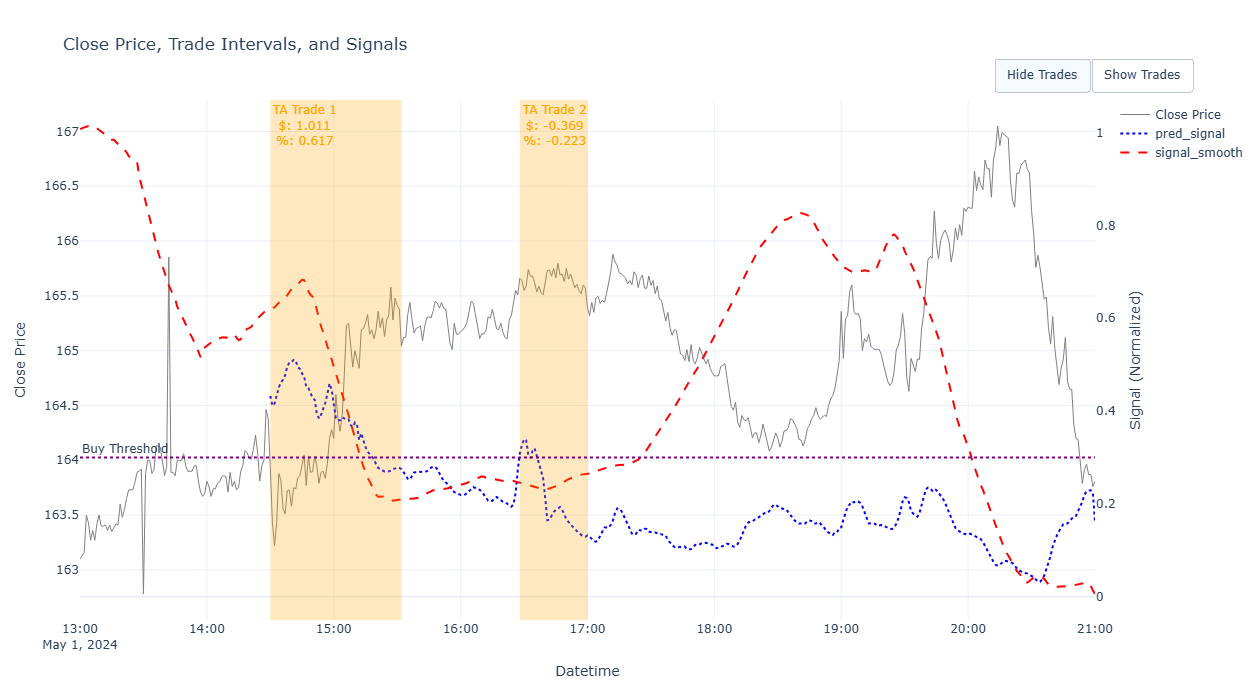


=== Performance for 2024-05-01 00:00:00 ===
Strategy Return ($): 0.642
Strategy Return (%): 0.392
Buy & Hold Return ($): -0.268
Buy & Hold Return (%): -0.164
Strategy Return Difference ($): 0.91
Strategy Return Improvement (%): 0.555
Trades Returns ($): [1.011, -0.369]
Trades Returns (%): [0.617, -0.223]


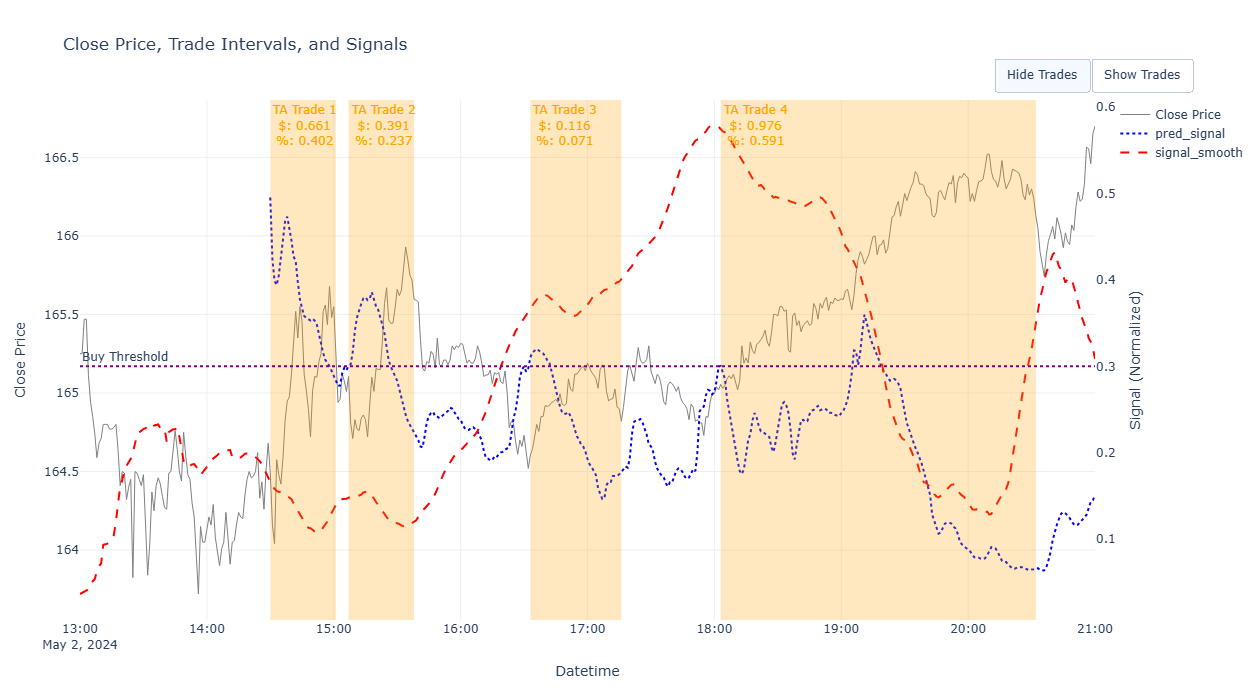


=== Performance for 2024-05-02 00:00:00 ===
Strategy Return ($): 2.144
Strategy Return (%): 1.303
Buy & Hold Return ($): 2.061
Buy & Hold Return (%): 1.252
Strategy Return Difference ($): 0.083
Strategy Return Improvement (%): 0.051
Trades Returns ($): [0.661, 0.391, 0.116, 0.976]
Trades Returns (%): [0.402, 0.237, 0.071, 0.591]


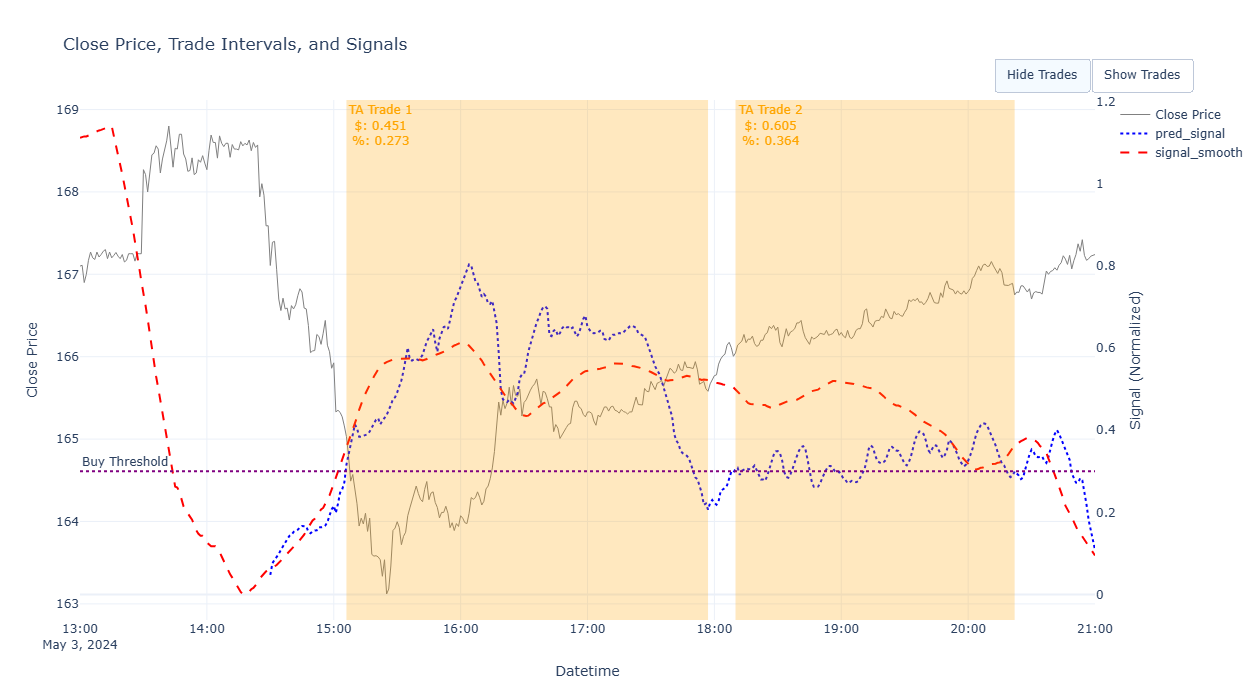


=== Performance for 2024-05-03 00:00:00 ===
Strategy Return ($): 1.37
Strategy Return (%): 0.82
Buy & Hold Return ($): 0.028
Buy & Hold Return (%): 0.017
Strategy Return Difference ($): 1.342
Strategy Return Improvement (%): 0.803
Trades Returns ($): [0.451, 0.605, 0.32]
Trades Returns (%): [0.273, 0.364, 0.192]


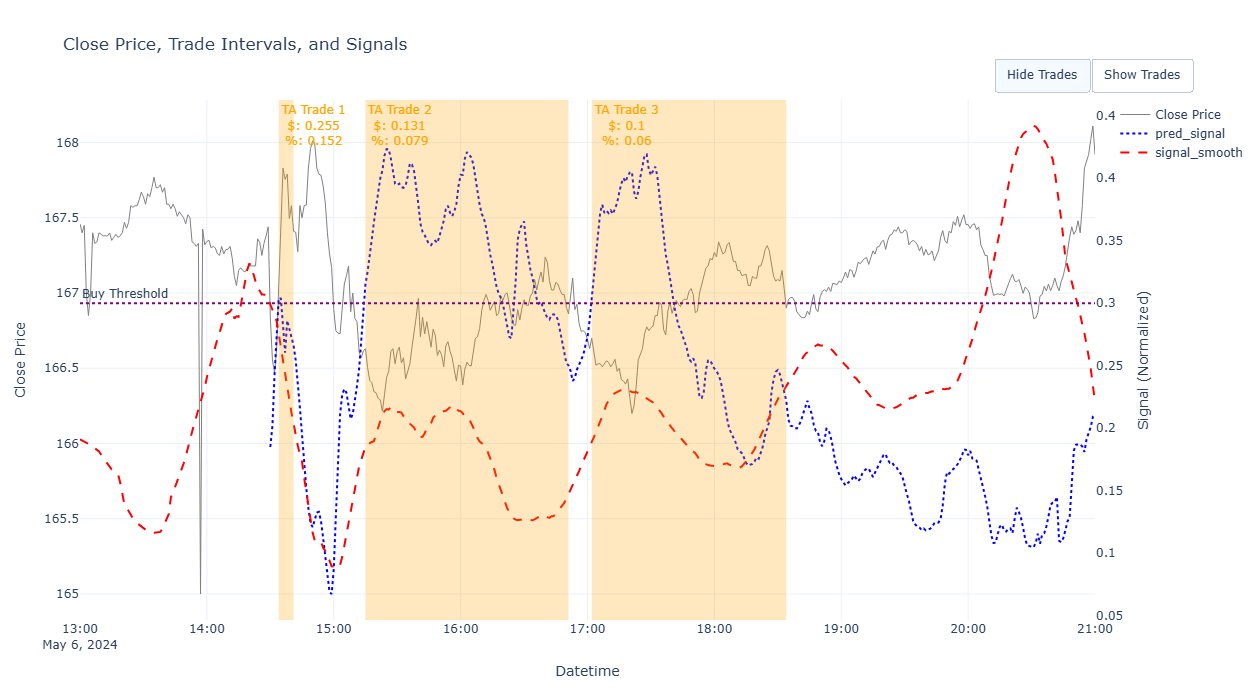


=== Performance for 2024-05-06 00:00:00 ===
Strategy Return ($): 0.486
Strategy Return (%): 0.291
Buy & Hold Return ($): 1.169
Buy & Hold Return (%): 0.701
Strategy Return Difference ($): -0.683
Strategy Return Improvement (%): -0.41
Trades Returns ($): [0.255, 0.131, 0.1]
Trades Returns (%): [0.152, 0.079, 0.06]


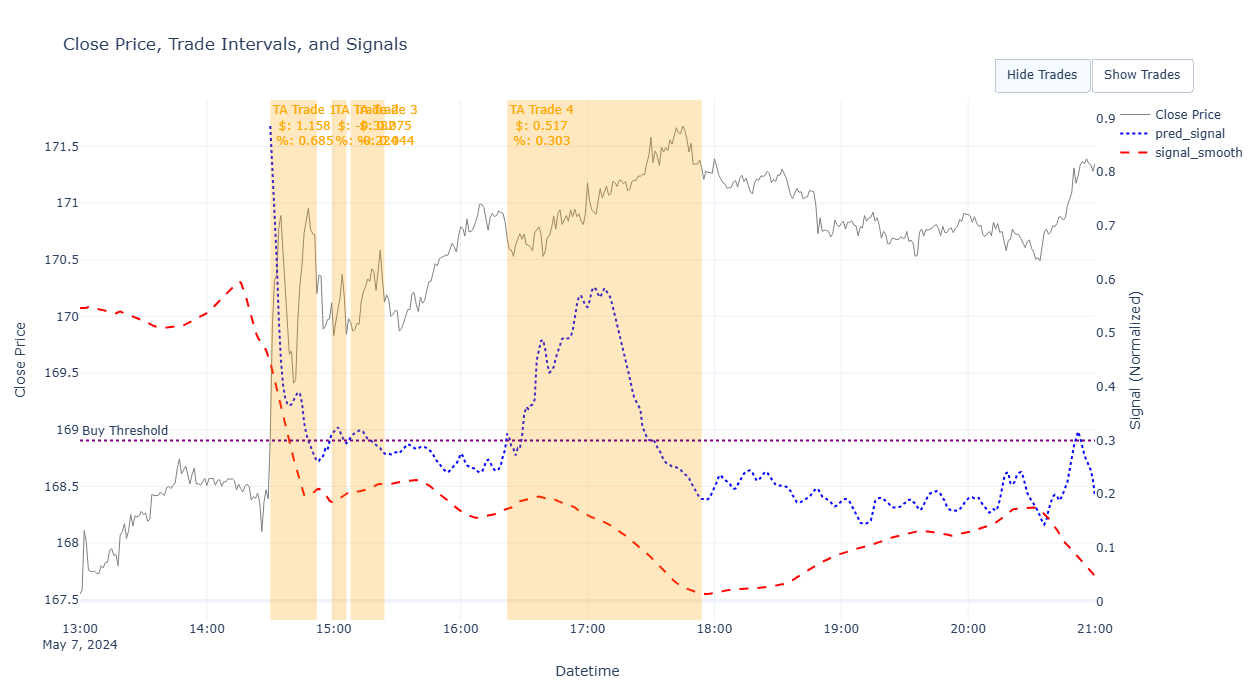


=== Performance for 2024-05-07 00:00:00 ===
Strategy Return ($): 1.371
Strategy Return (%): 0.811
Buy & Hold Return ($): 2.238
Buy & Hold Return (%): 1.324
Strategy Return Difference ($): -0.867
Strategy Return Improvement (%): -0.513
Trades Returns ($): [1.158, -0.382, 0.075, 0.517, 0.072]
Trades Returns (%): [0.685, -0.224, 0.044, 0.303, 0.042]


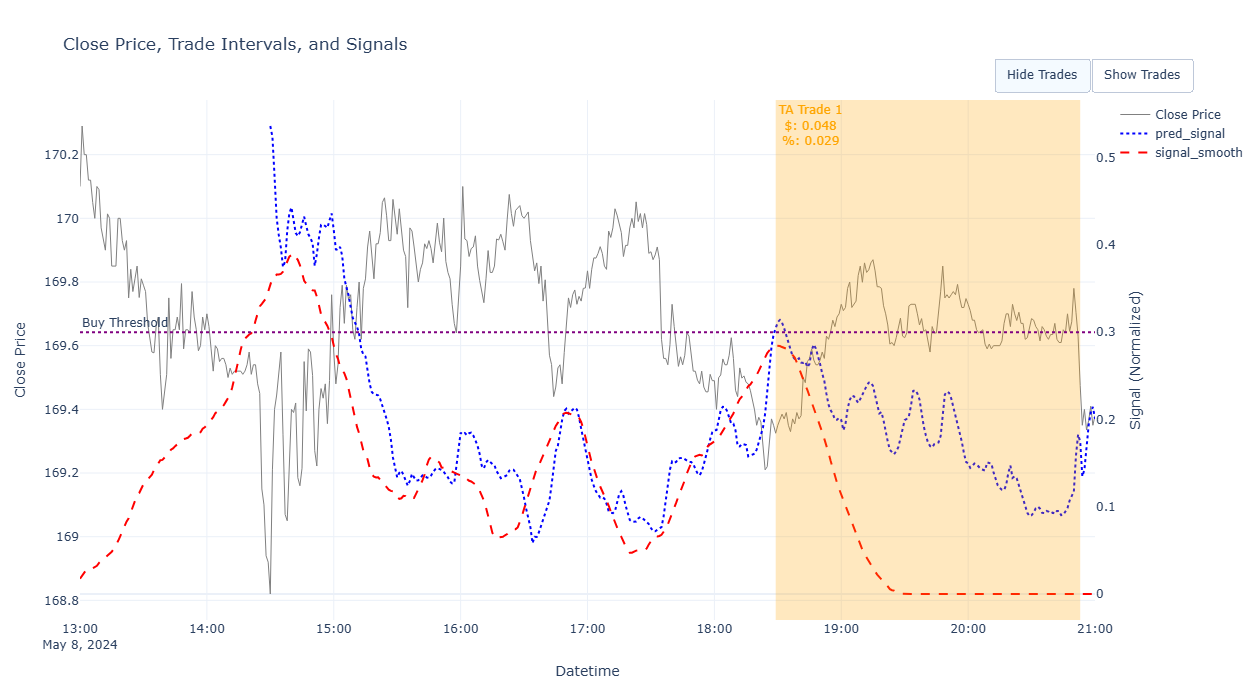


=== Performance for 2024-05-08 00:00:00 ===
Strategy Return ($): 0.048
Strategy Return (%): 0.028
Buy & Hold Return ($): 0.429
Buy & Hold Return (%): 0.254
Strategy Return Difference ($): -0.381
Strategy Return Improvement (%): -0.225
Trades Returns ($): [0.048]
Trades Returns (%): [0.029]


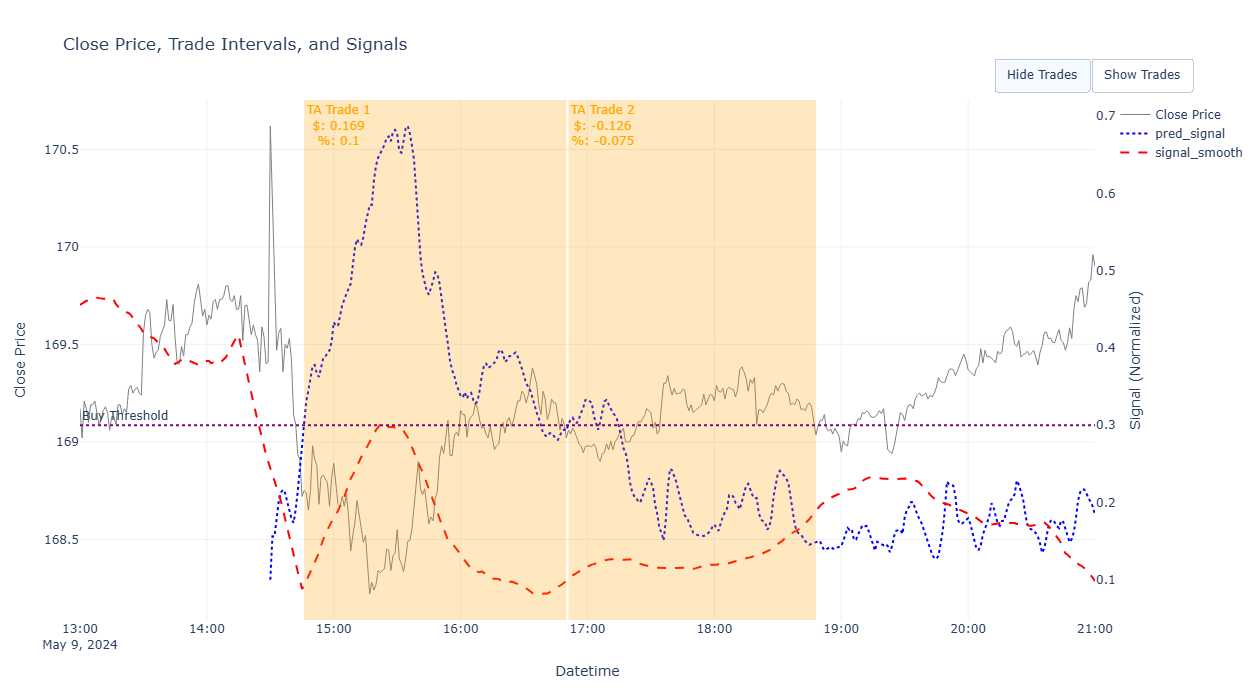


=== Performance for 2024-05-09 00:00:00 ===
Strategy Return ($): 0.042
Strategy Return (%): 0.025
Buy & Hold Return ($): -0.762
Buy & Hold Return (%): -0.447
Strategy Return Difference ($): 0.804
Strategy Return Improvement (%): 0.471
Trades Returns ($): [0.169, -0.126]
Trades Returns (%): [0.1, -0.075]


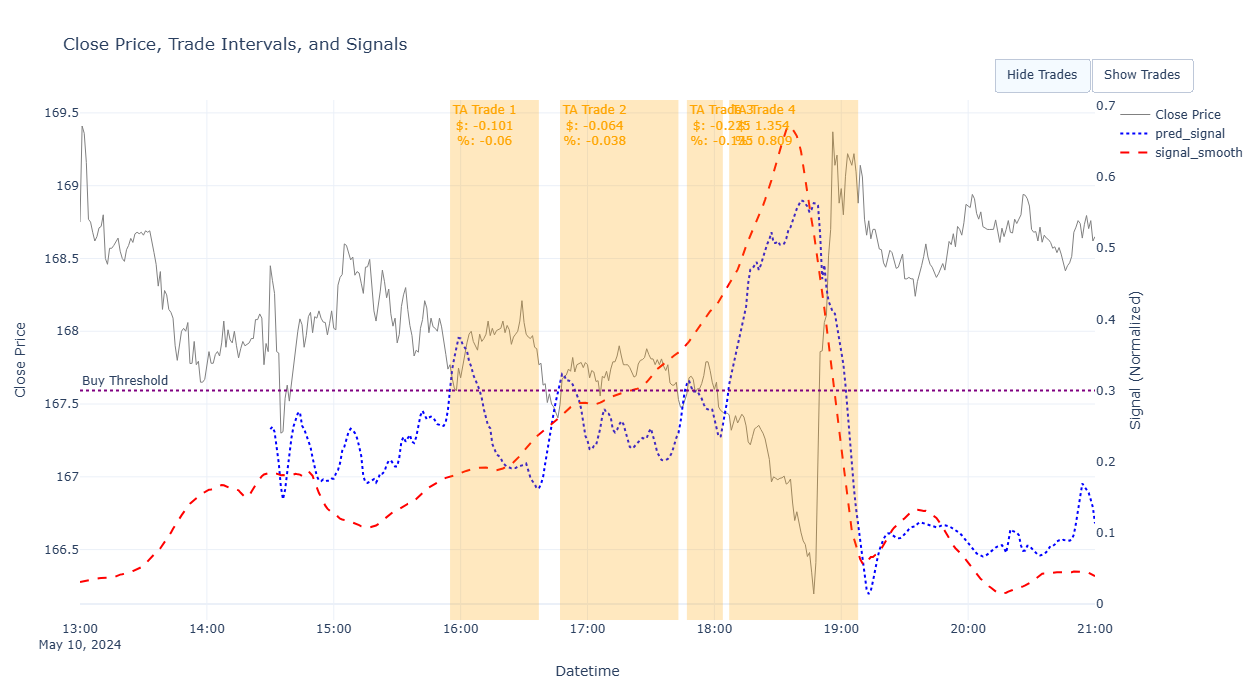


=== Performance for 2024-05-10 00:00:00 ===
Strategy Return ($): 0.964
Strategy Return (%): 0.572
Buy & Hold Return ($): 0.069
Buy & Hold Return (%): 0.041
Strategy Return Difference ($): 0.895
Strategy Return Improvement (%): 0.531
Trades Returns ($): [-0.101, -0.064, -0.225, 1.354]
Trades Returns (%): [-0.06, -0.038, -0.135, 0.809]


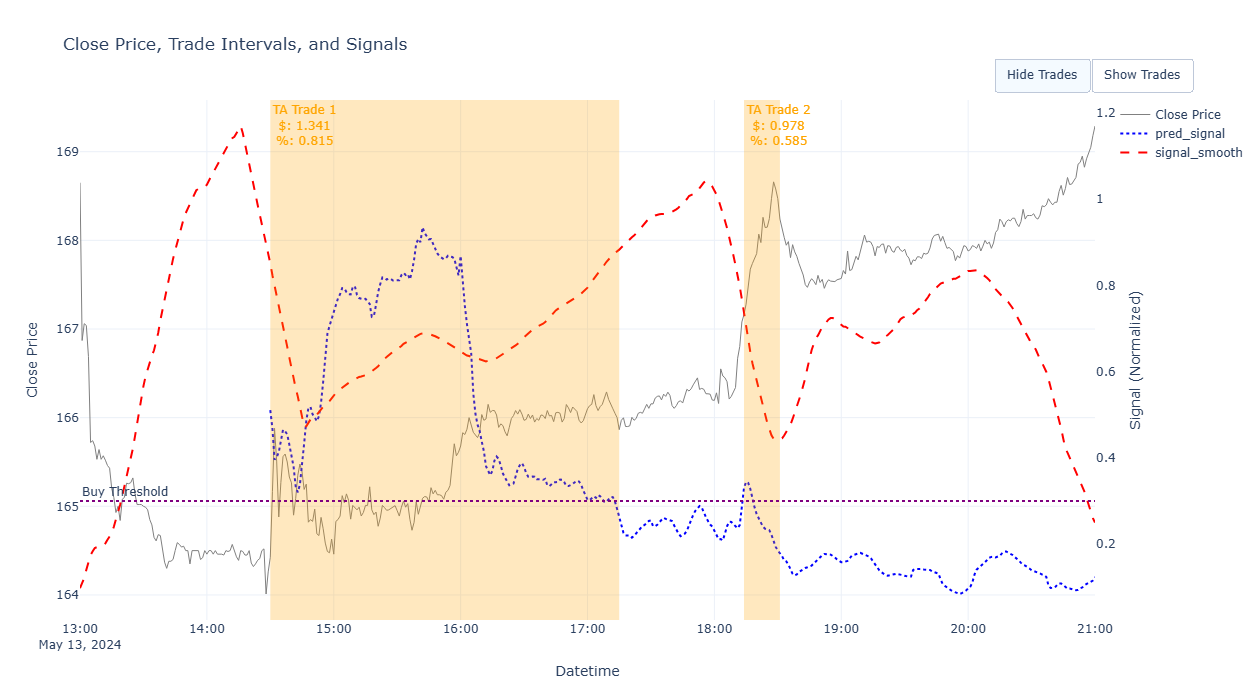


=== Performance for 2024-05-13 00:00:00 ===
Strategy Return ($): 2.318
Strategy Return (%): 1.409
Buy & Hold Return ($): 4.655
Buy & Hold Return (%): 2.83
Strategy Return Difference ($): -2.337
Strategy Return Improvement (%): -1.421
Trades Returns ($): [1.341, 0.978]
Trades Returns (%): [0.815, 0.585]


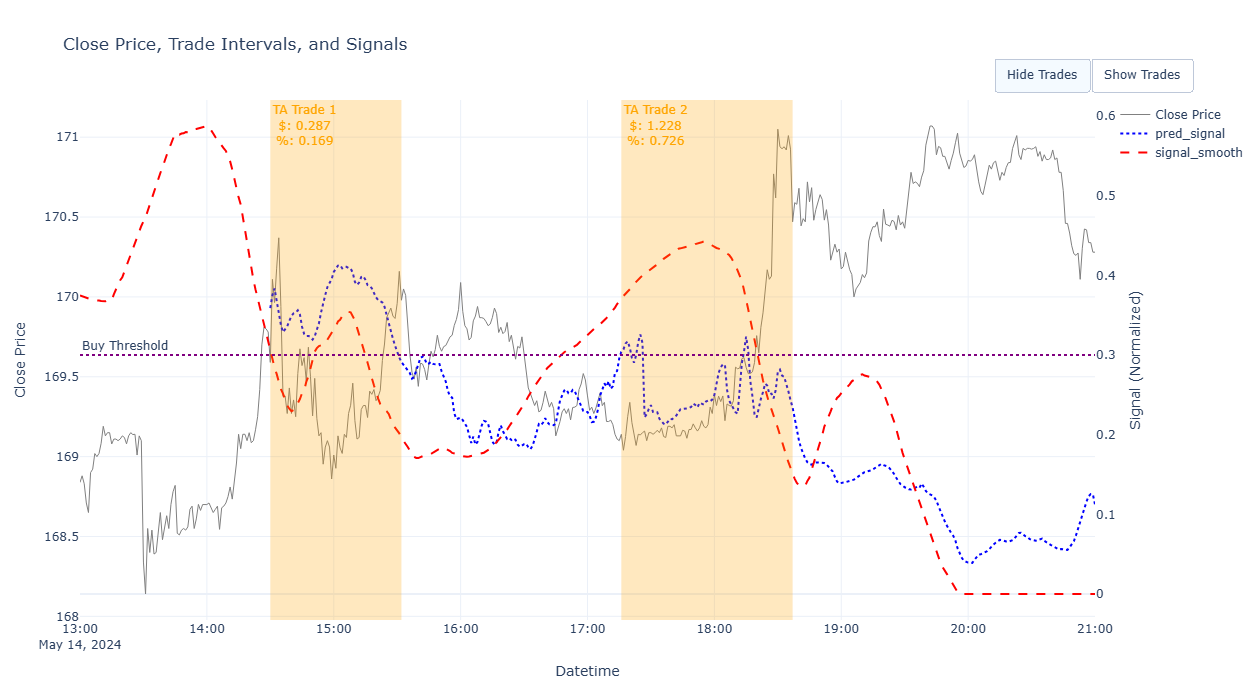


=== Performance for 2024-05-14 00:00:00 ===
Strategy Return ($): 1.516
Strategy Return (%): 0.894
Buy & Hold Return ($): 0.588
Buy & Hold Return (%): 0.347
Strategy Return Difference ($): 0.928
Strategy Return Improvement (%): 0.547
Trades Returns ($): [0.287, 1.228]
Trades Returns (%): [0.169, 0.726]


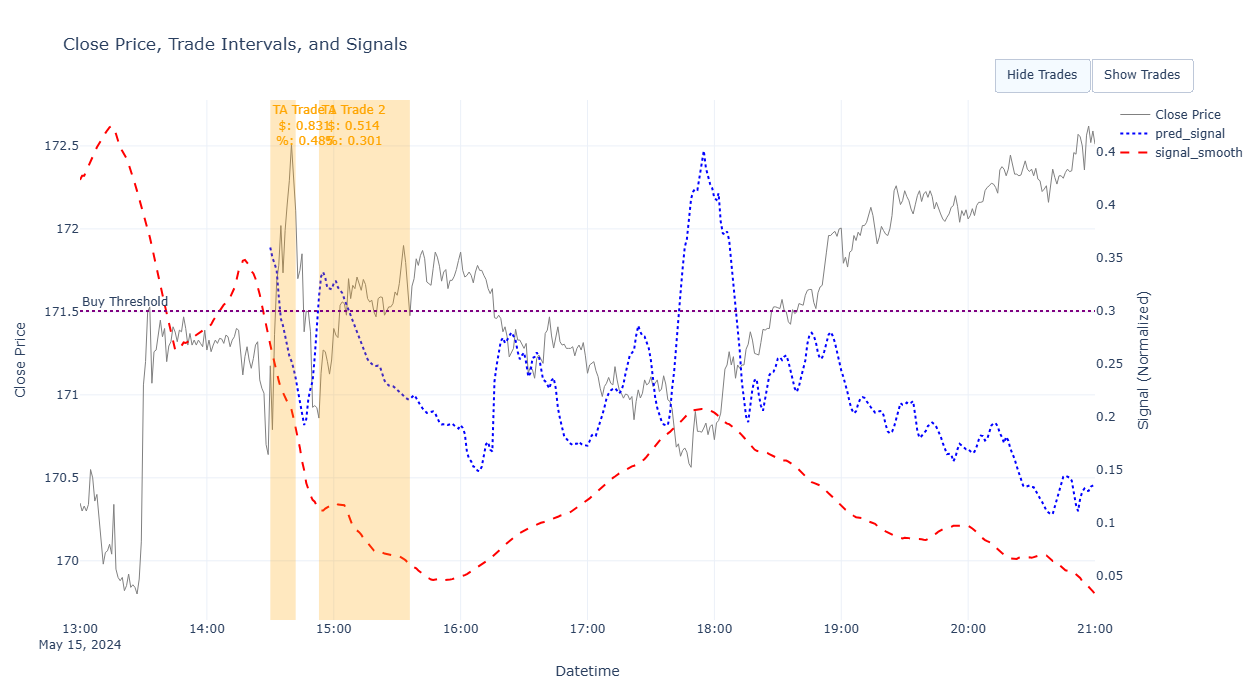


=== Performance for 2024-05-15 00:00:00 ===
Strategy Return ($): 3.202
Strategy Return (%): 1.87
Buy & Hold Return ($): 1.312
Buy & Hold Return (%): 0.766
Strategy Return Difference ($): 1.89
Strategy Return Improvement (%): 1.104
Trades Returns ($): [0.831, 0.514, 1.777]
Trades Returns (%): [0.485, 0.301, 1.041]


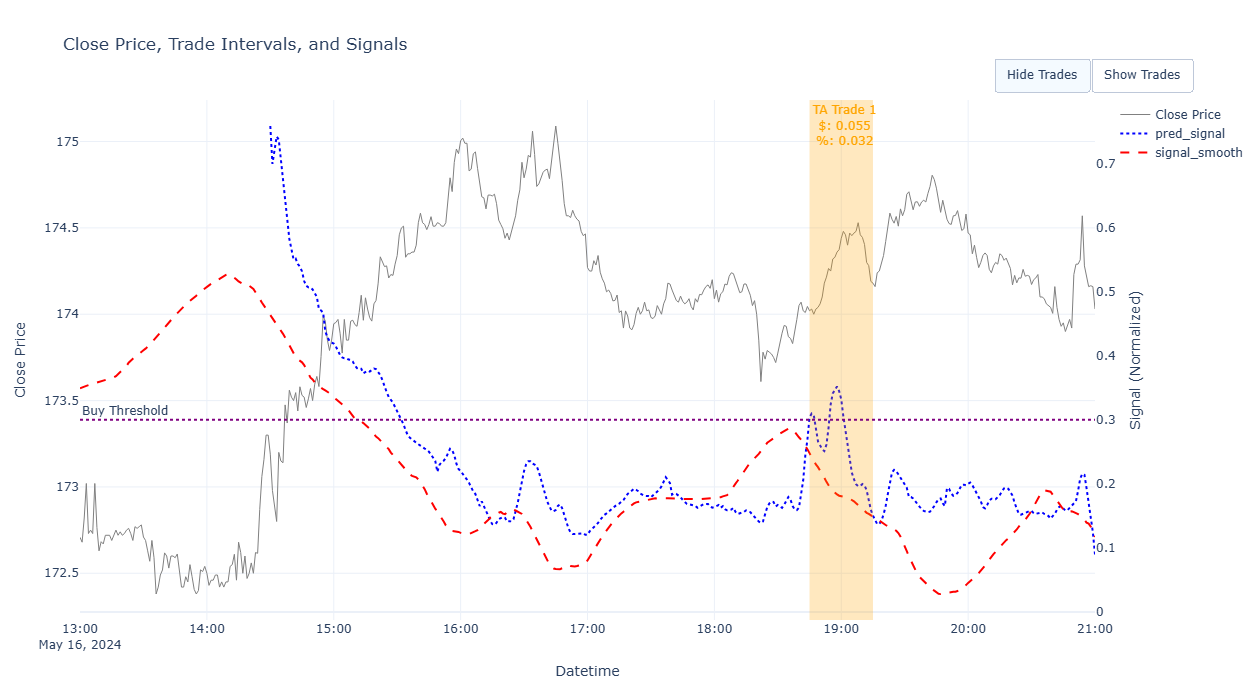


=== Performance for 2024-05-16 00:00:00 ===
Strategy Return ($): 0.055
Strategy Return (%): 0.032
Buy & Hold Return ($): 0.866
Buy & Hold Return (%): 0.5
Strategy Return Difference ($): -0.811
Strategy Return Improvement (%): -0.468
Trades Returns ($): [0.055]
Trades Returns (%): [0.032]


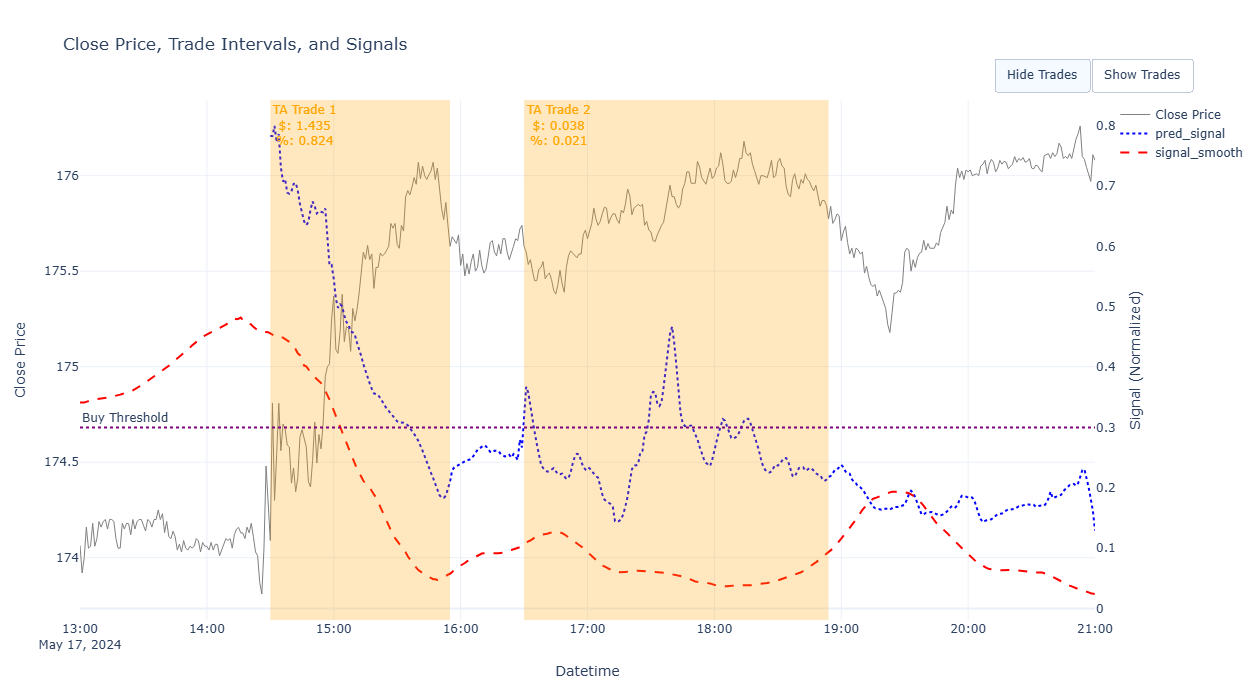


=== Performance for 2024-05-17 00:00:00 ===
Strategy Return ($): 1.473
Strategy Return (%): 0.846
Buy & Hold Return ($): 1.915
Buy & Hold Return (%): 1.1
Strategy Return Difference ($): -0.442
Strategy Return Improvement (%): -0.254
Trades Returns ($): [1.435, 0.038]
Trades Returns (%): [0.824, 0.021]


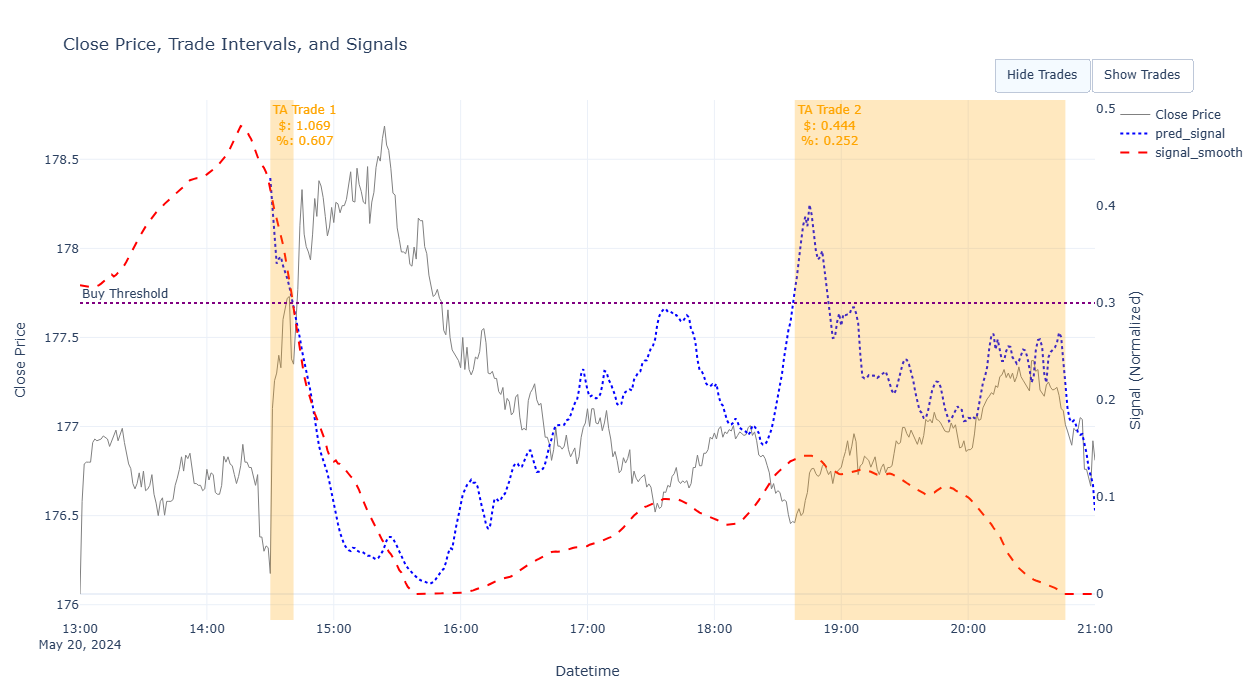


=== Performance for 2024-05-20 00:00:00 ===
Strategy Return ($): 1.513
Strategy Return (%): 0.859
Buy & Hold Return ($): 0.639
Buy & Hold Return (%): 0.363
Strategy Return Difference ($): 0.874
Strategy Return Improvement (%): 0.496
Trades Returns ($): [1.069, 0.444]
Trades Returns (%): [0.607, 0.252]


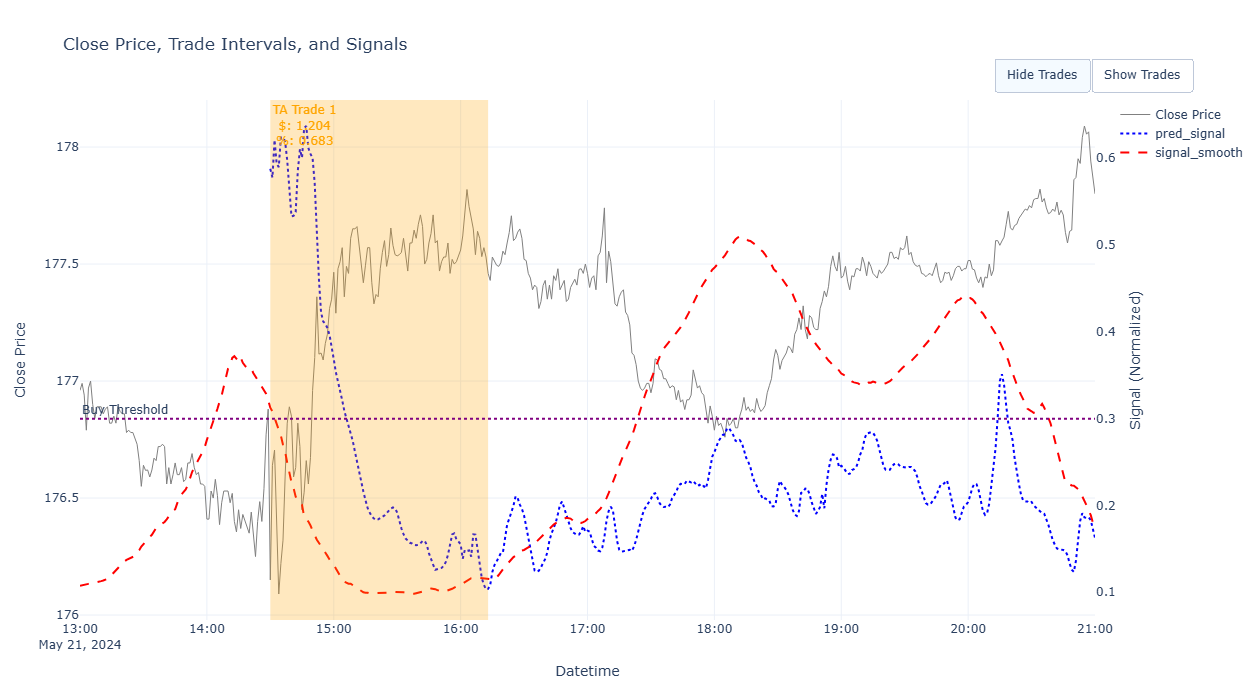


=== Performance for 2024-05-21 00:00:00 ===
Strategy Return ($): 1.377
Strategy Return (%): 0.781
Buy & Hold Return ($): 1.624
Buy & Hold Return (%): 0.922
Strategy Return Difference ($): -0.247
Strategy Return Improvement (%): -0.14
Trades Returns ($): [1.204, 0.093]
Trades Returns (%): [0.683, 0.053]


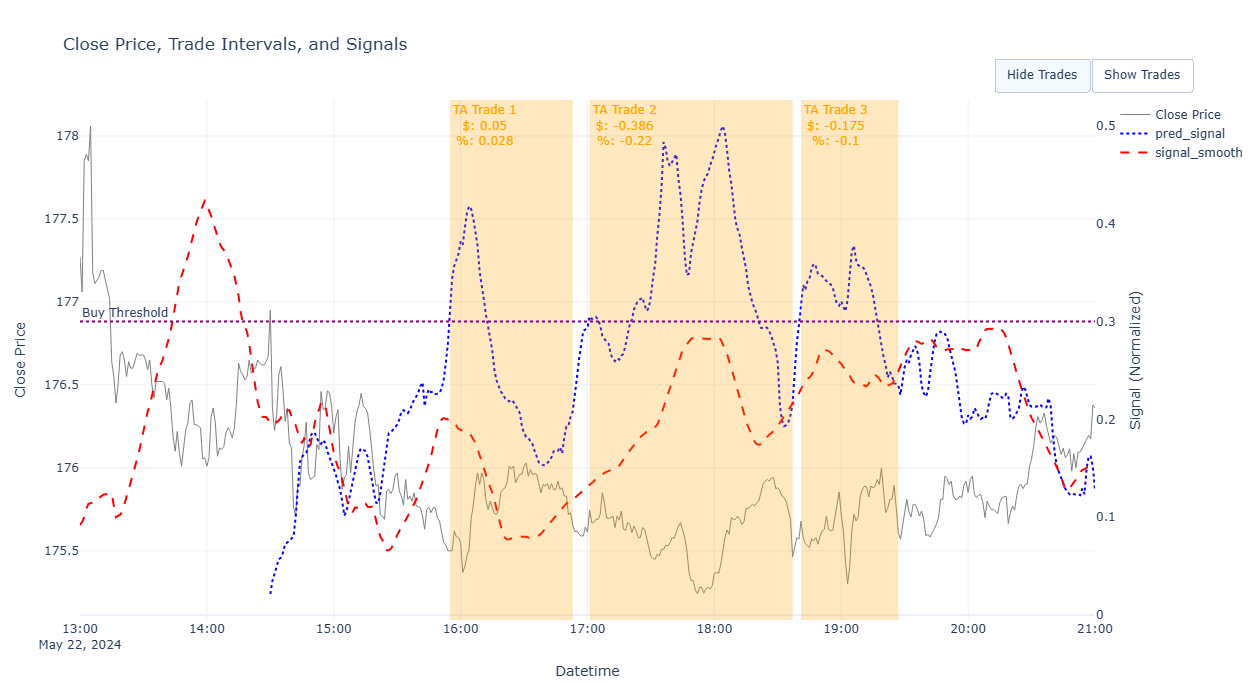


=== Performance for 2024-05-22 00:00:00 ===
Strategy Return ($): -0.512
Strategy Return (%): -0.289
Buy & Hold Return ($): -0.676
Buy & Hold Return (%): -0.382
Strategy Return Difference ($): 0.164
Strategy Return Improvement (%): 0.093
Trades Returns ($): [0.05, -0.386, -0.175]
Trades Returns (%): [0.028, -0.22, -0.1]


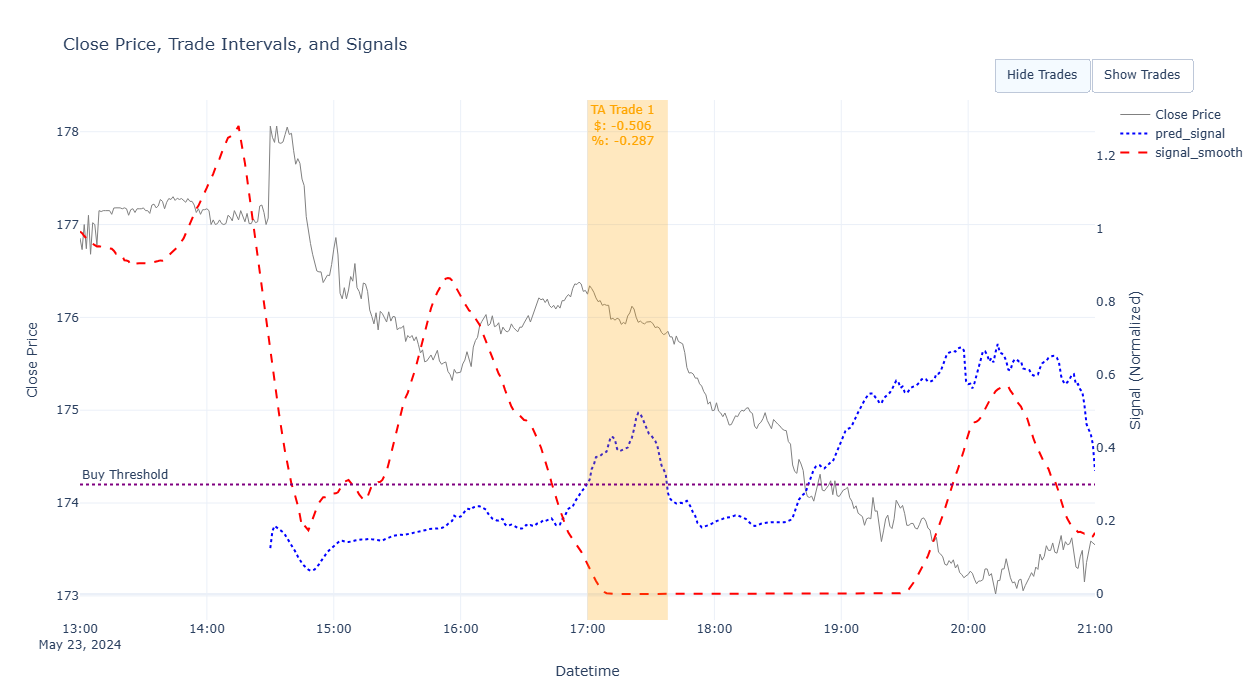


=== Performance for 2024-05-23 00:00:00 ===
Strategy Return ($): -1.1
Strategy Return (%): -0.618
Buy & Hold Return ($): -4.596
Buy & Hold Return (%): -2.58
Strategy Return Difference ($): 3.496
Strategy Return Improvement (%): 1.963
Trades Returns ($): [-0.506, -0.614]
Trades Returns (%): [-0.287, -0.353]


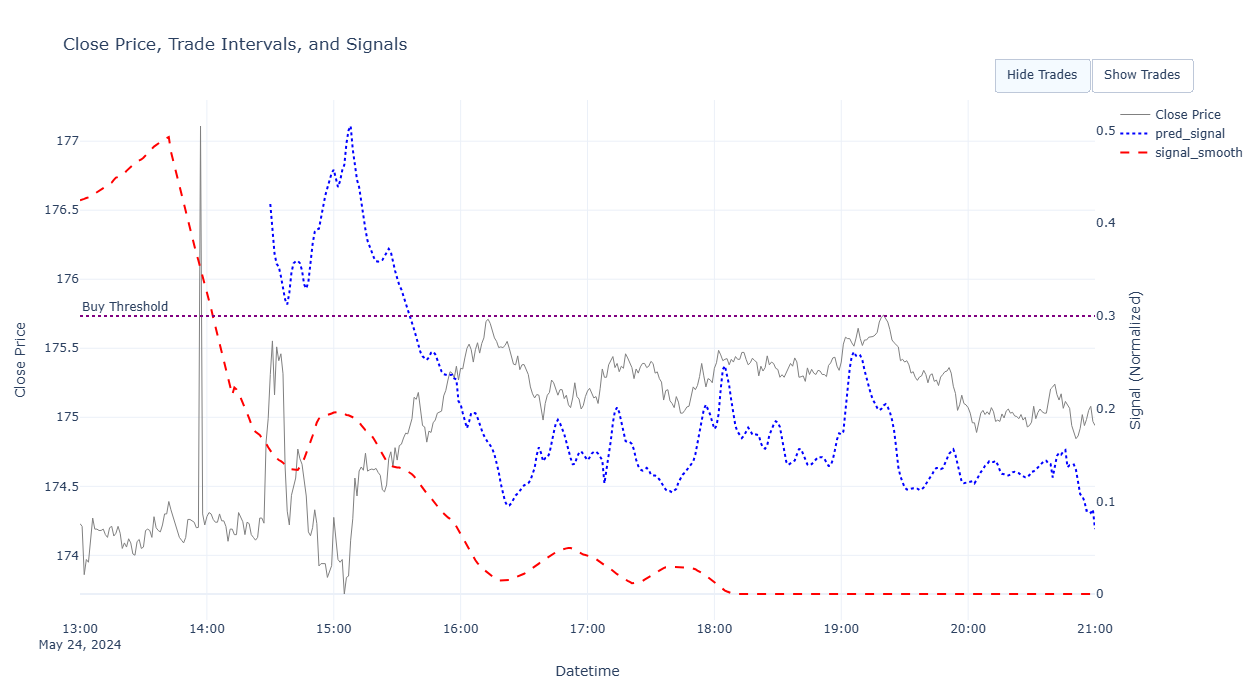


=== Performance for 2024-05-24 00:00:00 ===
Strategy Return ($): 0.0
Strategy Return (%): 0.0
Buy & Hold Return ($): -0.445
Buy & Hold Return (%): -0.254
Strategy Return Difference ($): 0.445
Strategy Return Improvement (%): 0.254
Trades Returns ($): []
Trades Returns (%): []


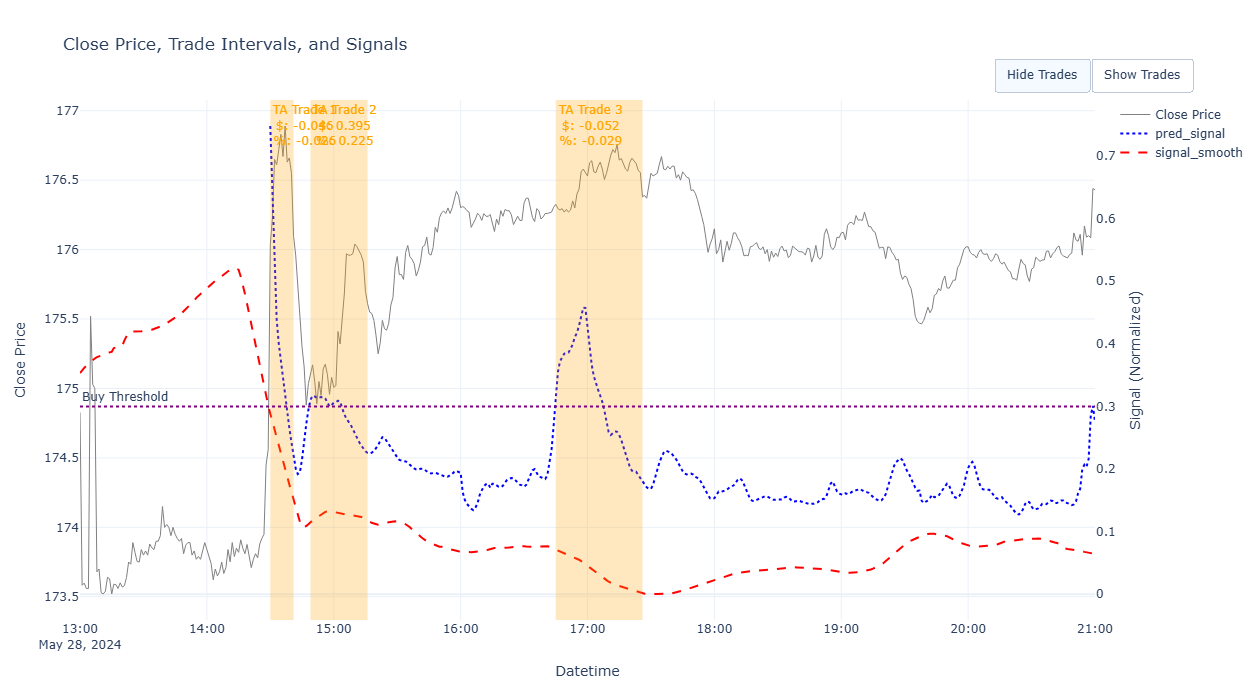


=== Performance for 2024-05-28 00:00:00 ===
Strategy Return ($): 0.192
Strategy Return (%): 0.109
Buy & Hold Return ($): 0.299
Buy & Hold Return (%): 0.17
Strategy Return Difference ($): -0.107
Strategy Return Improvement (%): -0.061
Trades Returns ($): [-0.046, 0.395, -0.052, -0.116]
Trades Returns (%): [-0.026, 0.225, -0.029, -0.066]


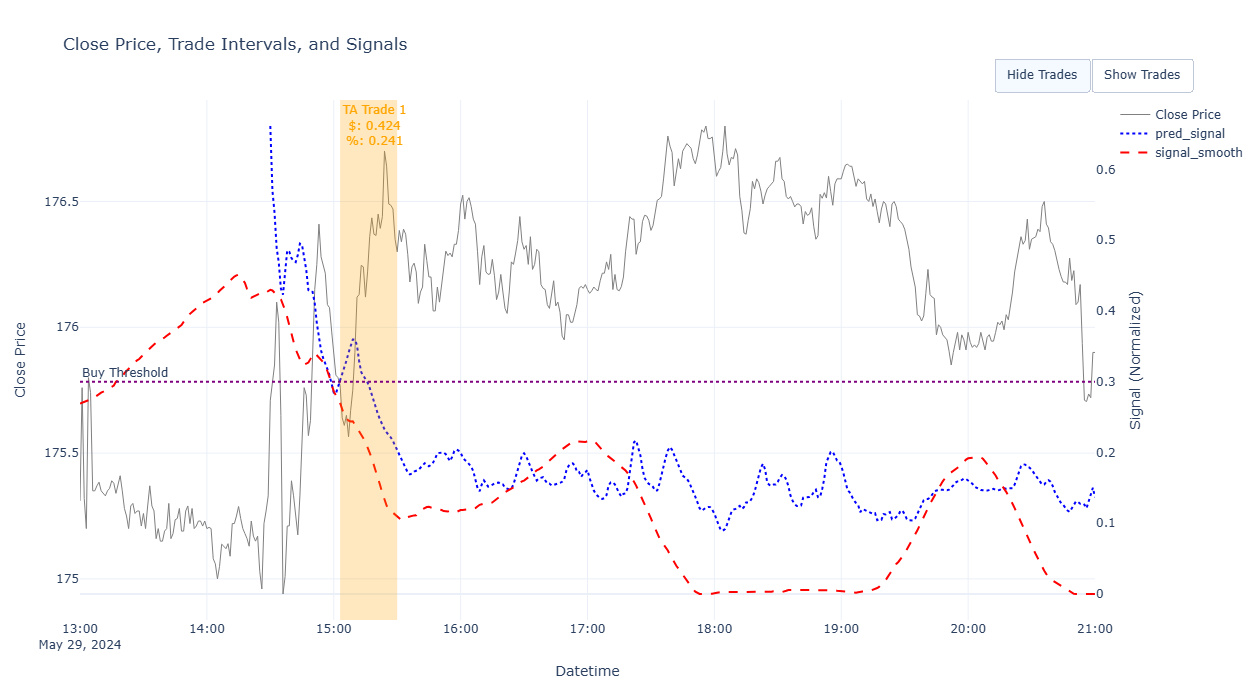


=== Performance for 2024-05-29 00:00:00 ===
Strategy Return ($): 0.424
Strategy Return (%): 0.241
Buy & Hold Return ($): 0.084
Buy & Hold Return (%): 0.048
Strategy Return Difference ($): 0.34
Strategy Return Improvement (%): 0.193
Trades Returns ($): [0.424]
Trades Returns (%): [0.241]


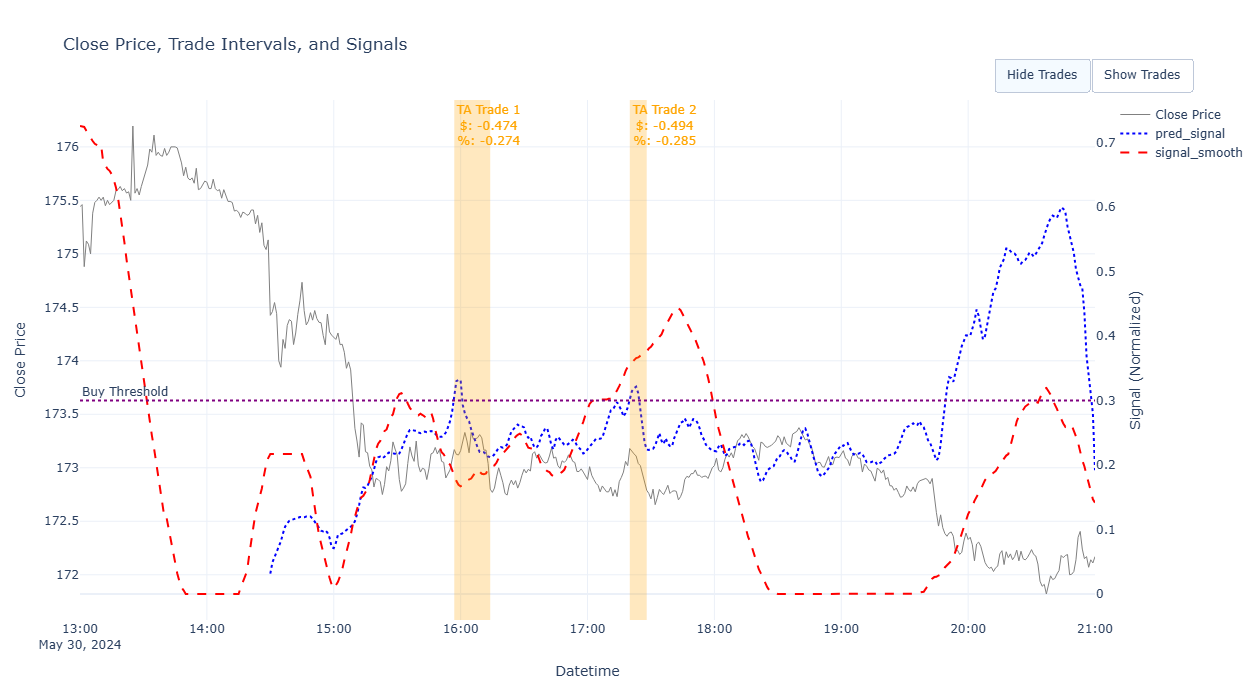


=== Performance for 2024-05-30 00:00:00 ===
Strategy Return ($): -1.321
Strategy Return (%): -0.757
Buy & Hold Return ($): -2.419
Buy & Hold Return (%): -1.386
Strategy Return Difference ($): 1.098
Strategy Return Improvement (%): 0.629
Trades Returns ($): [-0.474, -0.494, -0.293]
Trades Returns (%): [-0.274, -0.285, -0.17]


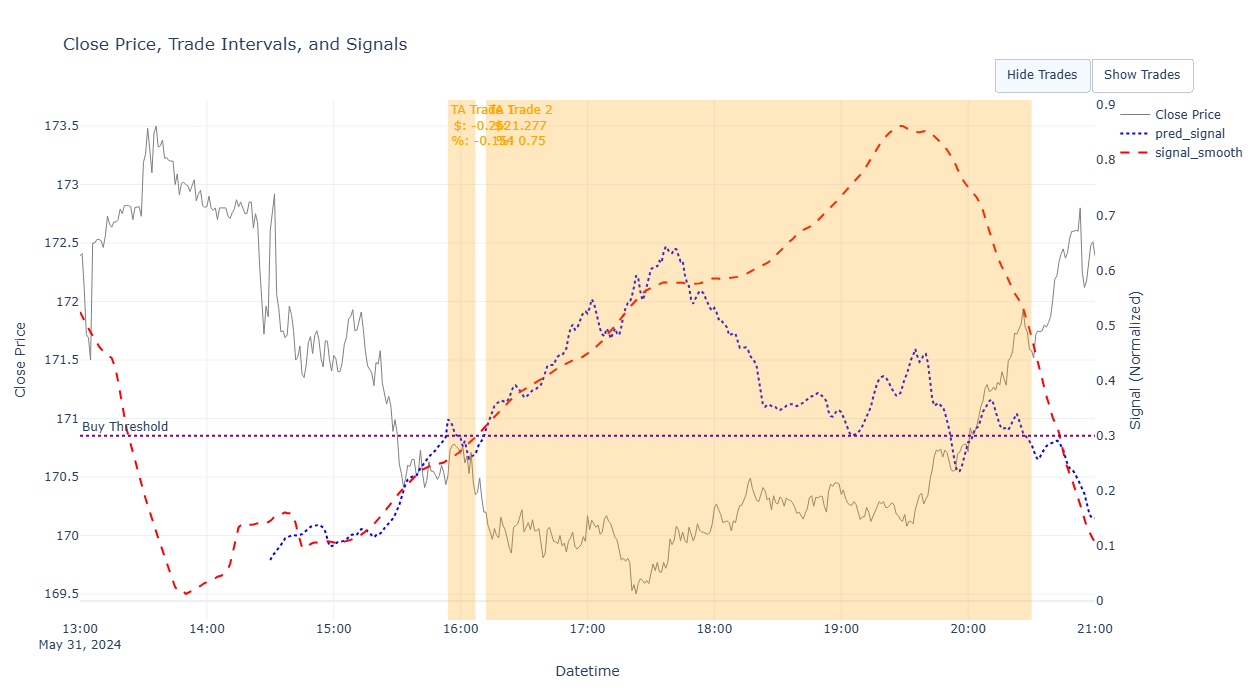


=== Performance for 2024-05-31 00:00:00 ===
Strategy Return ($): 1.015
Strategy Return (%): 0.588
Buy & Hold Return ($): -0.204
Buy & Hold Return (%): -0.118
Strategy Return Difference ($): 1.219
Strategy Return Improvement (%): 0.706
Trades Returns ($): [-0.262, 1.277]
Trades Returns (%): [-0.154, 0.75]

=== Summary for 2024-05 ===
{'Buy & Hold – each day ($)': 8.606,
 'Buy & Hold – each day (%)': 5.304,
 'Strategy Return ($)': 17.219,
 'Strategy Return (%)': 10.207,
 'Strategy Return Difference ($)': 8.613,
 'Strategy Return Improvement (%)': 4.903,
 'Trades Returns ($)': '53 trades',
 'Trades Returns (%)': '53 trades'}

=== Overall Summary (2023-10-12 → 2025-06-18) ===
Start date price: 2023-10-12 = 138.8817
  End date price:   2025-06-18 = 173.5576
One-time buy&hold gain: 34.67590000000001 

{'Buy & Hold – each day ($)': -77.566,
 'Buy & Hold – each day (%)': -42.219,
 'Strategy Return ($)': 314.538,
 'Strategy Return (%)': 197.742,
 'Strategy Return Difference ($)': 392.104,
 'St

In [14]:

year, month = map(int, month_to_check.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {month_to_check}")
else:
    print(f"\nPlotting days in {month_to_check}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_man,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
monthly_summary = plots.aggregate_performance(performance_month)
print(f"\n=== Summary for {month_to_check} ===")
pprint(monthly_summary)

# 4) Overall summary across ALL days, with date range
all_days_sorted = sorted(sim_results.keys())
start_date = all_days_sorted[0].date()
end_date   = all_days_sorted[-1].date()

overall_summary = plots.aggregate_performance(performance_all)
print(f"\n=== Overall Summary ({start_date} → {end_date}) ===")
start_ask = df_with_preds[df_with_preds.index.normalize() == pd.Timestamp(start_date)]['ask'].iloc[-1]
end_bid   = df_with_preds[df_with_preds.index.normalize() == pd.Timestamp(end_date)]['bid'].iloc[-1]
print(f"Start date price: {start_date} = {start_ask}")
print(f"  End date price:   {end_date} = {end_bid}")
print('One-time buy&hold gain:', end_bid-start_ask, '\n')
pprint(overall_summary)
